In [1]:
import os

import gc
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
from skimage.transform import rescale
from skimage.util import view_as_windows, random_noise
from torch.utils.data import DataLoader, random_split

In [2]:
# Percorso alla cartella che contiene le immagini
datasetPath = "dataset"

# Lista per salvare le immagini caricate
imgList = []

# Scorrimento di tutti i file nella cartella
i = 0
for fileName in os.listdir(datasetPath):
    if fileName.lower().endswith(".jpg"):
        filePath = os.path.join(datasetPath, fileName)
        img = np.array(Image.open(filePath)).astype(np.float32) / 255.0
        img = rescale(img, (1/1.66, 1/1.66, 1)) # Passaggio da 640x480 a 386x289
        imgList.append(img)

In [3]:
# Full Scale Histogram Stretching: prende un immagine x e la normalizzazione converte da (min;max) a (0;K-1)
def fshs(x, K=256):
    xmin = np.min(x)
    xmax = np.max(x)
    g = (K-1)*(x-xmin)/(xmax-xmin)
    return g

In [4]:
# Creazione rumore
def addNoise(img):
    # Scelgo casualmente se applicare un rumore sale e pepe o uno gaussiano
    randInt = 2   
    h,w,c = img.shape
    y = np.zeros_like(img)
    if randInt == 1:                    # Rumore gaussiano
        d = random.randint(10, 45)/255
        n = d*np.random.randn(h,w,c)
        y = img+n
    else:                               # Rumore sale e pepe
        sp = random_noise(img, mode="s&p")
        y = img*sp
    
    if y.max() > 1.0:
        y[y > 1.0] = 1.0
    if y.min() < 0.0:
        y[y < 0.0] = 0.0
    
    return y

In [5]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms
import numpy as np

class ImgListDataset(Dataset):
    def __init__(self, imgList):
        self.imgList = imgList
        self.target_size = (289, 386)  # Altezza, larghezza desiderata
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.target_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.imgList)

    def __getitem__(self, idx):
        img = self.imgList[idx]
        if isinstance(img, np.ndarray):
            img = self.transform(img)
        return img



In [6]:
# Divisione dell'intero dataset in training set, validation set e test set (Circa 80%, 10% e 10%)
trainSet, valSet, testSet = random_split(imgList, [0.8, 0.1, 0.1])

#windowShape = (96,96,3)
#scale = 0.5
#step = 24s

# Creazione dei dataset di immagini ricostruite (downscale-upscale)
trainSetNoise = []
valSetNoise = []
testSetNoise = []

for el in trainSet:
    imgNoise = addNoise(el)
    trainSetNoise.append(imgNoise)

for el in valSet:
    imgNoise = addNoise(el)
    valSetNoise.append(imgNoise)

for el in testSet:
    imgNoise = addNoise(el)
    testSetNoise.append(imgNoise)

1.0
0.0
1.0
0.0


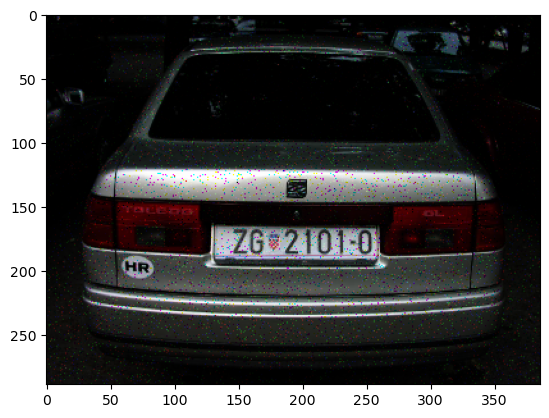

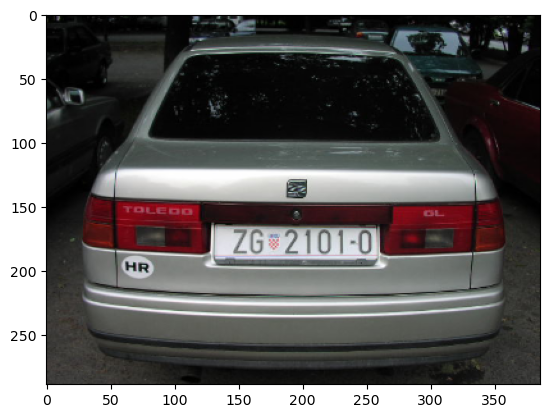

In [7]:
plt.figure()
plt.imshow(imgNoise)
print(np.max(imgNoise))
print(np.min(imgNoise))

plt.figure()
plt.imshow(el)
print(np.max(el))
print(np.min(el))